# Import Packages

Source : https://www.kaggle.com/benroshan/factors-affecting-campus-placement <br>
by Tito Tamaro

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,classification_report, confusion_matrix,r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
df = pd.read_csv('Placement_Data_Full_Class.csv',index_col='sl_no') # set sl_no sebagai index
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
sl_no,,,,,,,,,,,,,,
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [3]:
df.shape

(215, 14)

# Attributes Information

| Variable Name | Description | Data Type |
|--|--|--|
sl_no | Serial number atau nomor students (dijadikan index dan tidak akan diolah dalam data) | integer
gender | Gender dari students | string
ssc_p | Persentase Secondary Education  - 10th Grade | percentage
ssc_b | Board of Education (Central / Others), kalau di Indonesia seperti sekolah negeri / swasta | string
hsc_p | Persentase Higher Secondary Education - 12th Grade | percentage
hsc_b | Board of Education (Central/ Others) | string 
hsc_s | Specialization in Higher Secondary Education | string
degree_p | Degree Percentage | percentage
degree_t | Under Graduation - Field of degree education | string
workex | Pengalaman kerja students, value yes berarti sudah pernah bekerja, value no berarti belum pernah bekerja | string
etest_p | Test kelayakan kerja untuk students  | percentage
specialisation | Post Graduation - MBA (jenis MBA yang diambil) | string
mba_p | MBA percentage | percentage
status | Status kerja students, Placed menandakan sudah punya tempat bekerja dan Not Placed menandakan students belum bekerja | string
salary | Tawaran gaji yang diperoleh students dari perusahaan (corporate) | integer

Data merupakan _acedamic history_ pelajar dimana terdapat 14 features yang akan menentukan status pelajar, diterima atau tidak. Feature yang akan dijadikan target merupakan 'status'. 

# Goals

1. Which factor influenced a candidate in getting placed? - dari Kaggle
2. Does percentage matters for one to get placed? - dari Kaggle
3. Which degree specialization is much demanded by corporate? - dari Kaggle
4. Pemodelan yang dapat memprediksi students dapat bekerja atau tidak dengan features sebagai pengaruhnya

# EDA (Exploratory Data Analysis)

## Data Description

In [4]:
def dataframe_description(dataframe,samples=2): 
    bsDESC=[]
    for i in dataframe.columns:
        bsDESC.append([
            i, 
            dataframe[i].dtypes, 
            dataframe[i].isnull().sum(), 
            round((((dataframe[i].isnull().sum()) / (len(dataframe))) * 100),2),
            dataframe[i].nunique(), 
            dataframe[i].drop_duplicates().sample(samples).values
        ])
    dfDesc = pd.DataFrame(bsDESC,columns=['dataFeatures','dataType','nullValues','nullPercentage','unique','sample'])
    return dfDesc 

In [5]:
pd.DataFrame(dataframe_description(df))

,dataFeatures,dataType,nullValues,nullPercentage,unique,sample
0,gender,object,0,0.00,2,"[F, M]"
1,ssc_p,float64,0,0.00,103,"[54.4, 61.0]"
2,ssc_b,object,0,0.00,2,"[Central, Others]"
3,hsc_p,float64,0,0.00,97,"[83.83, 97.0]"
4,hsc_b,object,0,0.00,2,"[Central, Others]"
5,hsc_s,object,0,0.00,3,"[Commerce, Science]"
6,degree_p,float64,0,0.00,89,"[77.0, 67.5]"
7,degree_t,object,0,0.00,3,"[Others, Sci&Tech]"
8,workex,object,0,0.00,2,"[Yes, No]"
9,etest_p,float64,0,0.00,100,"[68.92, 94.0]"


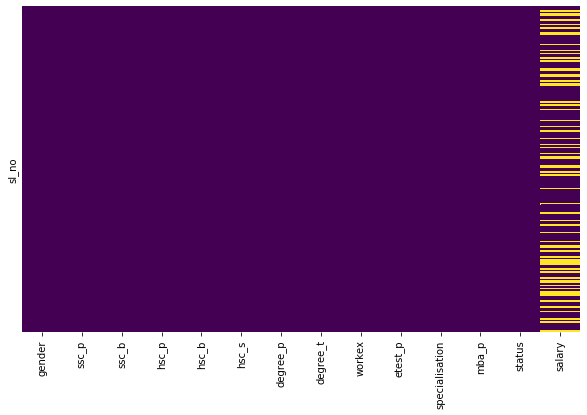

In [6]:
plt.figure(figsize=(10,6))

sns.heatmap(df.isna(), yticklabels=False, cmap='viridis', cbar=False)
plt.show()

Terdapat 67 null values pada salary, persentase null sebesar 31.16 sehingga akan dilakukan imputasi dengan menggunakan mean data

## Data Imputation

In [7]:
df['salary'] = df['salary'].fillna(df['salary'].mean())

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 1 to 215
Data columns (total 14 columns):
gender            215 non-null object
ssc_p             215 non-null float64
ssc_b             215 non-null object
hsc_p             215 non-null float64
hsc_b             215 non-null object
hsc_s             215 non-null object
degree_p          215 non-null float64
degree_t          215 non-null object
workex            215 non-null object
etest_p           215 non-null float64
specialisation    215 non-null object
mba_p             215 non-null float64
status            215 non-null object
salary            215 non-null float64
dtypes: float64(6), object(8)
memory usage: 25.2+ KB


Imputasi berhasil dilakukan

## Data Distribution

### Numerical Features

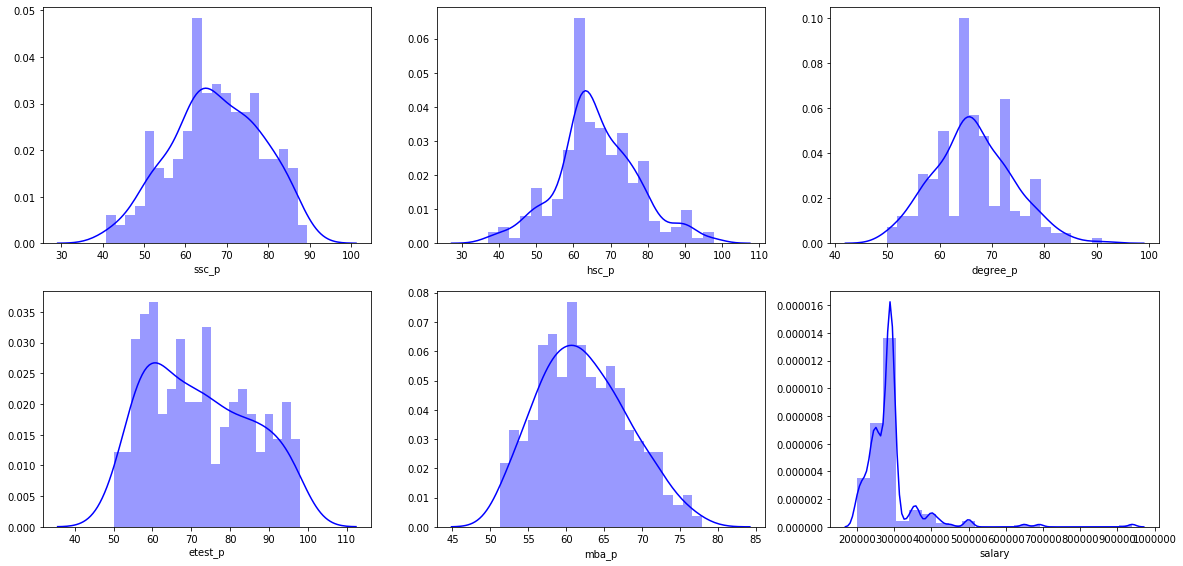

In [9]:
col = df.drop(['gender','ssc_b','hsc_b','hsc_s','degree_t','workex','specialisation','status'],axis=1)
columnList = list(col)
columnList

fig = plt.figure(figsize=[20,20])
for j,i in zip(columnList,range(1,7)):
    axes = fig.add_subplot(4,3,i)
    sns.distplot(df[j],bins=21,ax=axes, color='blue') # jumlah bins 1/10 jumlah data
plt.show()

### Categorical Features

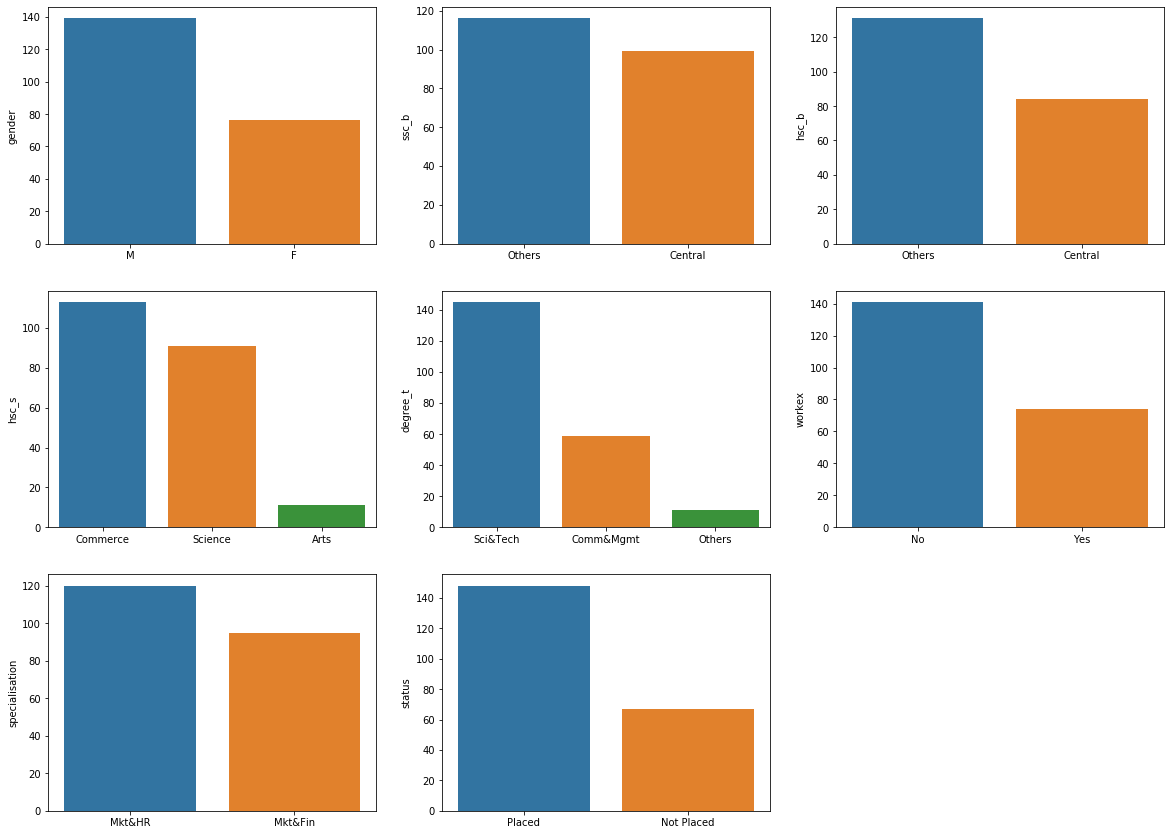

In [10]:
col2 = df.drop(['ssc_p','hsc_p','degree_p','etest_p','mba_p','salary'],axis=1)
columnList = list(col2)

fig = plt.figure(figsize=[20,20])
for j,i in zip(columnList,range(1,9)):
    axes = fig.add_subplot(4,3,i)
    z = df[j].value_counts()
    sns.barplot(df[j].unique(),z)
plt.show()

Dapat dilihat pada numerical features terdapat 1 grafik yang mengalami skewness yaitu features salary<br>
Sementara pada categorical features harus dieksplor lebih dalam lagi agar diperoleh informasi untuk menjawab goals

## Outliers

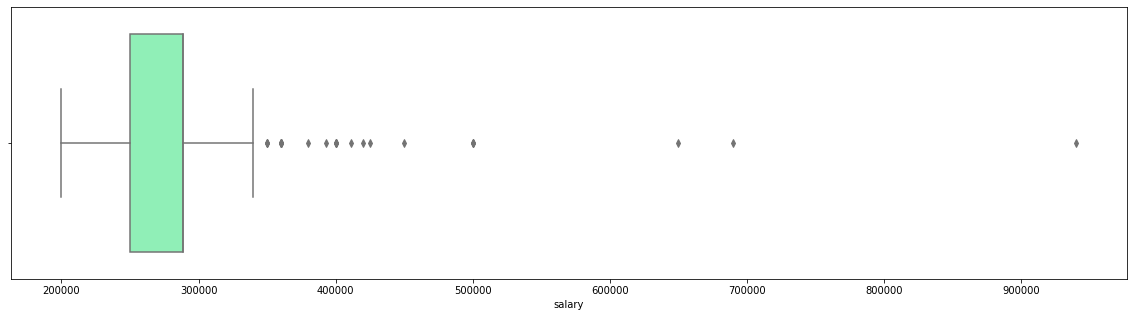

In [11]:
plt.figure(figsize=(20,5))
sns.boxplot(df['salary'],data=df,palette='rainbow')
plt.show()

Terdapat outlier pada features salary, namun hal ini <b>dibiarkan</b> karena hal ini mungkin untuk terjadi<br>
Proses pengubahan pada data dilakukan seminimal mungkin agar hasil tidak _misleading_

## Hipotesis Awal

- Univariate
    - Terdapat kaitan antara masing-masing nilai saat 10th grade, 12th grade, dan kuliah terhadap status kerja
    - Terdapat kaitan antara gender terhadap status kerja
    - Terdapat kaitan antara jenis penjurusan saat 12th grade dan kuliah terhadap status kerja
    - Terdapat kaitan antara nilai etest terhadap status kerja
    - Terdapat kaitan antara spesialisasi terhadap status kerja 
- Bivariate
    - Terdapat kaitan antara akumulasi nilai highschool, undergraduate, dan mba terhadap status kerja
    - Terdapat kaitan antara akumulasi nilai highschool, undergraduate, dan mba terhadap gaji

### Univariate

In [12]:
df[['ssc_p', 'ssc_b']].groupby(['ssc_b']).mean()

,ssc_p
ssc_b,
Central,66.143879
Others,68.662020


Tidak terdapat perbedaan yang signifikan pada students yang bersekolah di BOE central maupun others pada 10th Grade, BOE Others memiliki keunggulan 2 poin

In [13]:
df[['gender','ssc_p']].groupby(['gender']).mean()

,ssc_p
gender,
F,68.310921
M,66.752518


Tidak terdapat perbedaan nilai yang signifikan pada 10th Grade, students perempuan memiliki keunggulan 2 poin

In [14]:
df[['hsc_p', 'ssc_b']].groupby(['ssc_b']).mean()

,hsc_p
ssc_b,
Central,67.709310
Others,64.720707


Rata-rata students yang bersekolah di BOE Central memiliki kecenderungan nilai yang lebih baik (sebanyak 3 poin) dari students yang bersekolah di BEO Others saat memasuki high school (12th Grade)

In [15]:
df['ssc_hsc'] = df['hsc_p'] - df['ssc_p']
df['ssc_hsc'].mean()

-0.9702325581395349

Terdapat penurunan nilai students di 10th grade terhadap nilai students di 12th grade, secara rata-rata sebanyak 0.9 poin. 

In [16]:
df[['hsc_p', 'hsc_b']].groupby(['hsc_b']).mean()

,hsc_p
hsc_b,
Central,66.598571
Others,66.162977


Tidak terdapat perbedaan rata-rata nilai yang signifikan dari students 12th grade yang bersekolah di BOE central ataupun others 

In [17]:
df[['hsc_p', 'hsc_s']].groupby(['hsc_s']).mean()

,hsc_p
hsc_s,
Arts,62.745455
Commerce,68.999115
Science,63.456374


Students dengan rata-rata nilai tertinggi di 12th grade (68.99) memilih untuk masuk penjurusan Commerce, disusul oleh jurusan Science dengan rerata nilai 63.45 dan terakhir arts dengan rerata nilai 62.74 

In [18]:
df[['hsc_p', 'degree_t']].groupby(['degree_t']).mean()

,hsc_p
degree_t,
Comm&Mgmt,67.185379
Others,60.181818
Sci&Tech,65.385593


Students dengan nilai rata-rata tertinggi di 12th Grade (67.18) memilih untuk masuk jurusan Comm&Mgmt saat perkuliahan. Sementara students dengan nilai rerata tertinggi kedua (65.38) memilih untuk masuk jurusan Sci&Tech dan terakhr diikuti oleh others (rerata 60.18)

In [19]:
df['hsc_degree'] = df['degree_p'] - df['hsc_p']
df['hsc_degree'].mean()

0.037023255813953396

Nilai students saat perkuliahan rata-rata mengalami kenaikan apabila dibandingkan dengan nilai saat 12th grade sebanyak 0.03 point

In [20]:
df[['workex', 'degree_p']].groupby(['workex']).mean()

,degree_p
workex,
No,65.717872
Yes,67.613108


In [21]:
df[['workex', 'hsc_p']].groupby(['workex']).mean()

,hsc_p
workex,
No,65.222411
Yes,68.449595


In [22]:
df[['workex', 'ssc_p']].groupby(['workex']).mean()

,ssc_p
workex,
No,65.928652
Yes,69.922838


Dapat dilihat dari rata-rata nilai baik di 10th grade, 12th grade dan perkuliahan orang yang sudah pernah bekerja sebelumnya adalah orang dengan rata-rata nilai lebih tinggi daripada yang belum pernah bekerja.

In [23]:
pd.crosstab(df['gender'],df['status'],normalize='all')

status,Not Placed,Placed
gender,,
F,0.130233,0.223256
M,0.181395,0.465116


Students dengan gender laki-laki memiliki kemungkinan lebih besar untuk dapat bekerja setelah kuliah dengan persentase 46.51%

In [24]:
pd.crosstab(index=df['status'],columns=df['ssc_b'],values=df['ssc_p'],aggfunc='mean',normalize='all')

ssc_b,Central,Others
status,,
Not Placed,0.224577,0.219914
Placed,0.271041,0.284469


In [25]:
pd.crosstab(index=df['status'],columns=df['hsc_b'],values=df['ssc_p'],aggfunc='mean',normalize='all')

hsc_b,Central,Others
status,,
Not Placed,0.226327,0.220467
Placed,0.271707,0.281500


Dapat dilihat bahwa students di sekolah 10th grade dan 12th grade dengan BOE others memiliki peluang kerja lebih baik dibandingkan dengan BOE central

In [26]:
pd.crosstab(df['workex'],df['status'],normalize='all')

status,Not Placed,Placed
workex,,
No,0.265116,0.390698
Yes,0.046512,0.297674


Students dengan status sudah pernah bekerja memiliki kemungkinan lebih buruk untuk dapat bekerja setelah kuliah dengan persentase 29.76% sementara students yang belum pernah bekerja memiliki kemungkinan lebih besar yaitu 39.06%

In [27]:
pd.crosstab(df['hsc_s'],df['status'],normalize='all')

status,Not Placed,Placed
hsc_s,,
Arts,0.023256,0.027907
Commerce,0.158140,0.367442
Science,0.130233,0.293023


Dari penjurusan saat 12th grade, dapat dilihat peluang terbesar students untuk dapat bekerja (setelah kuliah) adalah di jurusan commerce dengan persentase 36.74% 

In [28]:
pd.crosstab(df['degree_t'],df['status'],normalize='all')

status,Not Placed,Placed
degree_t,,
Comm&Mgmt,0.200000,0.474419
Others,0.027907,0.023256
Sci&Tech,0.083721,0.190698


Dari penjurusan saat kuliah dapat dilihat peluang terbesar students untuk dapat bekerja (setelah kuliah) adalah di jurusan Comm & Mgmt dengan persentase 47.44%

In [29]:
pd.crosstab(df['specialisation'],df['status'],normalize='all')

status,Not Placed,Placed
specialisation,,
Mkt&Fin,0.116279,0.441860
Mkt&HR,0.195349,0.246512


Dari penjurusan saat spesialisasi (MBA degree) dapat dilihat peluang terbesar students untuk dapat bekerja (setelah kuliah) adalah di jurusan Mkt & Fin dengan persentase 44.1%

### Bivariate

(6, 0)

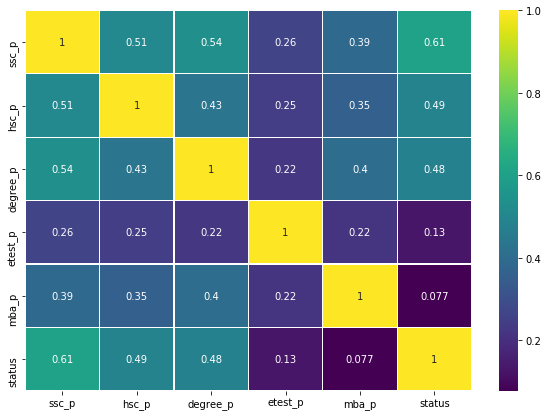

In [30]:
nilai = df.drop(['gender','ssc_b','hsc_b','hsc_s','degree_t','workex','specialisation','salary','ssc_hsc','hsc_degree'],axis=1)
nilai['status']=nilai['status'].replace('Placed',1) # dibuat 1.1 agar dapat terlihat pengaruhnya
nilai['status']=nilai['status'].replace('Not Placed',0) # dibuat 1.1 agar dapat terlihat pengaruhnya

plt.figure(figsize=(10,7))
x = sns.heatmap(nilai.corr(),annot=True,linewidths=0.2,cmap='viridis')
x.set_ylim(6,0)

Berikut adalah heatmap dari korelasi nilai pada students yang telah mendapatkan pekerjaan, dapat dilihat bahwa nilai yang paling mempengaruhi untuk students mendapatkan pekerjaan adalah 10th grade, 12th grade, bachelor degree, etest, dan spesialisasi. Dapat disimpulkan bahwa students yang unggul dari 10th grade akan cenderung mendapatkan peluang untuk bekerja yang lebih besar

(6, 0)

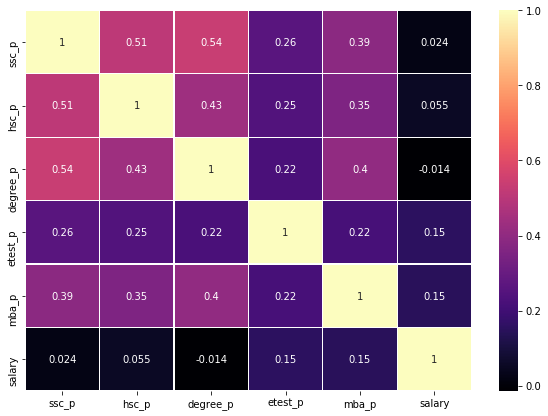

In [31]:
gaji = df.drop(['gender','ssc_b','hsc_b','hsc_s','degree_t','workex','specialisation','ssc_hsc','hsc_degree','status'],axis=1)

plt.figure(figsize=(10,7))
x = sns.heatmap(gaji.corr(),annot=True,linewidths=0.2,cmap='magma')
x.set_ylim(6,0)

Berikut adalah heatmap dari korelasi gaji dengan nilai students, dapat dilihat bahwa gaji mempunyai hubungan terkuat dengan nilai yang ada pada spesialisation (MBA program) dan etest yang dilakukan kampus.

# Feature Engineering

In [32]:
df.drop(['ssc_hsc','hsc_degree','ssc_b','hsc_b','salary'],axis=1,inplace=True) # features yang tidak relevan dengan target

### Changing categorical to numerical features

In [33]:
df['gender']=df['gender'].map({'M':1,'F':0})

In [34]:
df['hsc_s']=df['hsc_s'].map({'Commerce':1,'Science':0,'Arts':2})

In [35]:
df['degree_t']=df['degree_t'].map({'Sci&Tech':0,'Comm&Mgmt':1,'Others':2})

In [36]:
df['workex']=df['workex'].map({'Yes':1,'No':0})

In [37]:
df['specialisation']=df['specialisation'].map({'Mkt&HR':0,'Mkt&Fin':1})

In [38]:
df['status']=df['status'].map({'Placed':1,'Not Placed':0})

### Dummies

In [39]:
df=pd.get_dummies(df,columns=['hsc_s','degree_t'],drop_first=True)

# Modelling - Machine Learning

In [40]:
X = df.drop('status',axis=1)
y = df['status']

## Scaling

In [41]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

## Logistic Regression

In [43]:
logres = LogisticRegression()
model1 = logres.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [80]:
skor1 = model1.score(X_test,y_test)
skor1

0.8703703703703703

In [45]:
prediksi1 = logres.predict(X_test)

In [46]:
print(classification_report(y_test, prediksi1))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.90      0.93      0.91        40

    accuracy                           0.87        54
   macro avg       0.84      0.82      0.83        54
weighted avg       0.87      0.87      0.87        54



(2, 0)

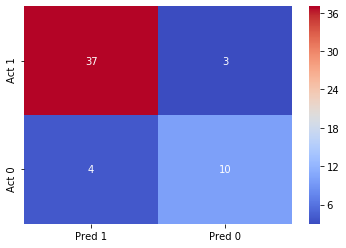

In [47]:
cm1 = confusion_matrix(y_test,prediksi1,labels=[1,0])
df_cm1 = pd.DataFrame(cm1,columns=['Pred 1', 'Pred 0'],index=['Act 1', 'Act 0'])
x = sns.heatmap(df_cm1, annot=True, cmap='coolwarm')
x.set_ylim(2,0)

## K Neighbors Classifier

In [48]:
classifier_knn=KNeighborsClassifier()
model2=classifier_knn.fit(X_train,y_train)

In [81]:
skor2 = model2.score(X_test,y_test)
skor2

0.8333333333333334

In [50]:
prediksi2 = classifier_knn.predict(X_test)

In [51]:
print(classification_report(y_test, prediksi2))

              precision    recall  f1-score   support

           0       0.86      0.43      0.57        14
           1       0.83      0.97      0.90        40

    accuracy                           0.83        54
   macro avg       0.84      0.70      0.73        54
weighted avg       0.84      0.83      0.81        54



(2, 0)

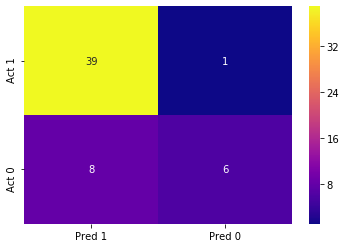

In [52]:
cm2 = confusion_matrix(y_test,prediksi2,labels=[1,0])
df_cm2 = pd.DataFrame(cm2,columns=['Pred 1', 'Pred 0'],index=['Act 1', 'Act 0'])
x = sns.heatmap(df_cm2, annot=True, cmap='plasma')
x.set_ylim(2,0)

## Random Forest Classifier

In [53]:
classifier_rfc=RandomForestClassifier() # n_estimator hanya tebakan
model3=classifier_rfc.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [82]:
skor3 = model3.score(X_test,y_test)
skor3

0.8333333333333334

In [55]:
prediksi3 = classifier_rfc.predict(X_test)

In [56]:
print(classification_report(y_test, prediksi3))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64        14
           1       0.86      0.93      0.89        40

    accuracy                           0.83        54
   macro avg       0.79      0.75      0.77        54
weighted avg       0.83      0.83      0.83        54



(2, 0)

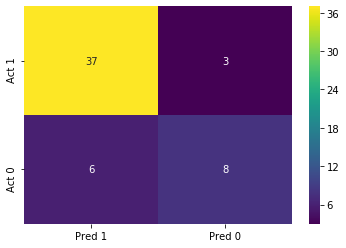

In [57]:
cm3 = confusion_matrix(y_test,prediksi3,labels=[1,0])
df_cm3 = pd.DataFrame(cm3,columns=['Pred 1', 'Pred 0'],index=['Act 1', 'Act 0'])
x = sns.heatmap(df_cm3, annot=True, cmap='viridis')
x.set_ylim(2,0)

Dari ketiga pemodelan diatas dapat diambil kesimpulan bahwa pemodelan terbaik adalah menggunakan Logistic Regression dengan total TP dan TN sebanyak 47 data.
Untuk selanjutnya akan dilakukan hyper tuning untuk memprediksi hasil yang lebih baik lagi

# Parameter Tuning

In [58]:
from sklearn.model_selection import GridSearchCV

### Logistic Regression Best Parameter

In [59]:
params1 = {
    "solver":['liblinear','newton-cg','sag','saga','lbfgs'],
    "max_iter":[100,200,300]
          }

In [60]:
model1_tuning = GridSearchCV(logres, params1, cv=3, n_jobs=-1, verbose=1)
model1_tuning.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    9.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_iter': [100, 200, 300],
                         'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                    'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [84]:
skor4 = model1_tuning.score(X_test,y_test)
skor4

0.8333333333333334

In [62]:
model1_tuning.best_params_

{'max_iter': 100, 'solver': 'newton-cg'}

In [63]:
prediksi4 = model1_tuning.predict(X_test)

In [64]:
print(classification_report(y_test, prediksi4))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64        14
           1       0.86      0.93      0.89        40

    accuracy                           0.83        54
   macro avg       0.79      0.75      0.77        54
weighted avg       0.83      0.83      0.83        54



(2, 0)

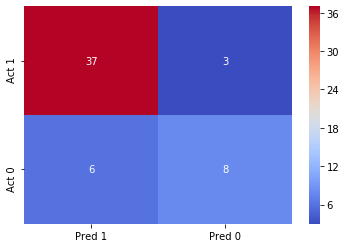

In [65]:
cm4 = confusion_matrix(y_test,prediksi4,labels=[1,0])
df_cm4 = pd.DataFrame(cm4,columns=['Pred 1', 'Pred 0'],index=['Act 1', 'Act 0'])
x = sns.heatmap(df_cm4, annot=True, cmap='coolwarm')
x.set_ylim(2,0)

### K Nearest Neighbors Best Parameter

In [66]:
params2 = {
    "n_neighbors":range(1,70,2),
    "weights":['uniform','distance'],
    'p':[2,1] 
}

In [67]:
model2_tuning = GridSearchCV(classifier_knn, params2, cv=3, n_jobs=-1, verbose=1)
model2_tuning.fit(X_train, y_train)

Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    1.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': range(1, 70, 2), 'p': [2, 1],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [85]:
skor5 = model2_tuning.score(X_test,y_test)
skor5

0.8333333333333334

In [69]:
model2_tuning.best_params_

{'n_neighbors': 13, 'p': 2, 'weights': 'distance'}

In [70]:
prediksi5 = model2_tuning.predict(X_test)

In [71]:
print(classification_report(y_test, prediksi5))

              precision    recall  f1-score   support

           0       0.86      0.43      0.57        14
           1       0.83      0.97      0.90        40

    accuracy                           0.83        54
   macro avg       0.84      0.70      0.73        54
weighted avg       0.84      0.83      0.81        54



(2, 0)

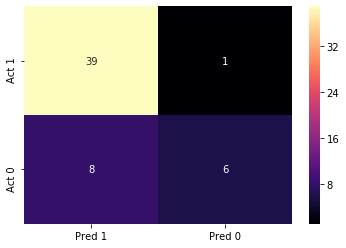

In [72]:
cm5 = confusion_matrix(y_test,prediksi5,labels=[1,0])
df_cm5 = pd.DataFrame(cm5,columns=['Pred 1', 'Pred 0'],index=['Act 1', 'Act 0'])
x = sns.heatmap(df_cm5, annot=True, cmap='magma')
x.set_ylim(2,0)

### Random Forest Classifier Best Parameter

In [73]:
params3 = {
    "n_estimators":range(1,100),
    "max_depth":range(1,75) 
}

In [74]:
model3_tuning = GridSearchCV(classifier_rfc, params3, cv=3, n_jobs=-1, verbose=1)
model3_tuning.fit(X_train, y_train)

Fitting 3 folds for each of 7326 candidates, totalling 21978 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1807 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 3207 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 5007 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7207 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 9807 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 12807 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 16207 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 20007 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 21971 out of 21978 | elapsed:  9.1min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 21978 out of 21978 | elapsed:  9.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` param

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [86]:
skor6 = model3_tuning.score(X_test,y_test)
skor6

0.8333333333333334

In [76]:
model3_tuning.best_params_

{'max_depth': 31, 'n_estimators': 33}

In [77]:
prediksi6 = model3_tuning.predict(X_test)

In [78]:
print(classification_report(y_test, prediksi6))

              precision    recall  f1-score   support

           0       0.86      0.43      0.57        14
           1       0.83      0.97      0.90        40

    accuracy                           0.83        54
   macro avg       0.84      0.70      0.73        54
weighted avg       0.84      0.83      0.81        54



(2, 0)

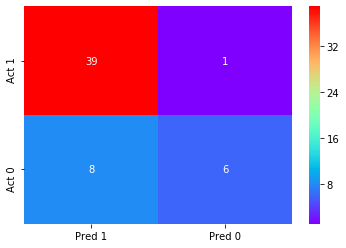

In [79]:
cm6 = confusion_matrix(y_test,prediksi6,labels=[1,0])
df_cm6 = pd.DataFrame(cm6,columns=['Pred 1', 'Pred 0'],index=['Act 1', 'Act 0'])
x = sns.heatmap(df_cm6, annot=True, cmap='rainbow')
x.set_ylim(2,0)

## Summary

In [87]:
model=pd.DataFrame({'Model':['LogisticRegression','KNeighborsClassifier',
                             'RandomForestClassifier','LogisticRegressionTuning'
                            ,'KNeighborsClassifierTuning','RandomForestClassifierTuning'],
                  'Score':[skor1,skor2,skor2,skor4,skor5,skor6]})
model.sort_values('Score',ascending=False)

,Model,Score
0,LogisticRegression,0.870370
1,KNeighborsClassifier,0.833333
2,RandomForestClassifier,0.833333
3,LogisticRegressionTuning,0.833333
4,KNeighborsClassifierTuning,0.833333
5,RandomForestClassifierTuning,0.833333


# Kesimpulan

1. Nilai berpengaruh terhadap peluang mendapatkan kerja, dari EDA dapat dilihat bahwa students yang unggul dari 10th grade memiliki peluang yang lebih besar untuk memperoleh pekerjaan
2. Students yang unggul mimilih jurusan:
    - Commerce saat 12th grade
    - Comm & Mgmt saat bachelor degree
    - Mkt & Fin saat higher secondary education (master / S2)
3. Salary dipengaruhi oleh gelar, apabila memiliki gelar MBA / spesialisasi students akan mendapatkan gaji yang lebih besar
4. Pemodelan terbaik diberikan oleh Logistic Regression (tanpa tuning) dengan skor 0.87, dengan jumlah TP dan NP sebesar 47 students